## Feature Engineering 

This notebook will continue on with the scoring feature but will now shift the focus onto scoring-related derived features such as: dropoff_zone_hoteness, trip_duration_varibility and travel_time_to_hotspot (once the hotspot model is ready) We will start with building dropoff_zone_hotness we will be using Jan_Feb as historical reference. We will be grouping pickups by: pickup_zone, pick_up_day_of_week, pickup hour (time_of_day)

We will then count number of pickups to get "hotness score" and then merge the score into the March-April data in order to hopefully simulate real-time supoport


** We will use March–April to build features (like dropoff frequency), but not to train the prediction model --> does not break the idea of just using Jan-Feb initally

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import asksaveasfilename


In [21]:
Tk().withdraw()
jan_feb_path = askopenfilename(title="Select the cleaned Jan–Feb file")
df_jf = pd.read_csv(jan_feb_path, parse_dates=['tpep_pickup_datetime'])

In [22]:
#  Building the hotness table from Jan–Feb pickups
hotness_table = (
    df_jf
    .groupby(['pickup_zone', 'pickup_day_of_week', 'pickup_hour'])
    .size()
    .reset_index(name='pickup_count')
)


In [23]:
# Load the cleaned March–April file
ma_path = askopenfilename(title="Select the cleaned March–April file")
df_ma = pd.read_csv(ma_path, parse_dates=['tpep_dropoff_datetime'])
df_ma['tpep_dropoff_datetime'] = pd.to_datetime(df_ma['tpep_dropoff_datetime'], errors='coerce')


# Add dropoff day/hour for hotness matching
df_ma['dropoff_day_of_week'] = df_ma['tpep_dropoff_datetime'].dt.dayofweek
df_ma['dropoff_hour'] = df_ma['tpep_dropoff_datetime'].dt.hour

In [24]:
# Merge hotness score into March–April based on dropoff context
df_ma = df_ma.merge(
    hotness_table,
    left_on=['dropoff_zone', 'dropoff_day_of_week', 'dropoff_hour'],
    right_on=['pickup_zone', 'pickup_day_of_week', 'pickup_hour'],
    how='left'
)

#reanmes the columns for clarity
df_ma.rename(columns={
    'pickup_zone_x': 'pickup_zone',
    'pickup_day_of_week_x': 'pickup_day_of_week',
    'pickup_hour_x': 'pickup_hour'
}, inplace=True)

In [25]:
# Clean up and rename
df_ma.rename(columns={'pickup_count': 'dropoff_zone_hotness'}, inplace=True)
df_ma['dropoff_zone_hotness'] = df_ma['dropoff_zone_hotness'].fillna(0)

In [26]:
# Generate a default file name
default_filename = "Cleaned_March_April_with_Hotness.csv"

# Hide the root window
Tk().withdraw()

# Open Save File Dialog
save_path = asksaveasfilename(
    initialfile=default_filename,
    title="Save cleaned March–April data with dropoff hotness",
    defaultextension=".csv",
    filetypes=[("CSV files", "*.csv")]
)

# Save if path selected
if save_path:
    df_ma.to_csv(save_path, index=False)
    print(f"\nFile saved successfully: {save_path}")
    print(f"Final shape: {df_ma.shape}")
else:
    print("\n Save cancelled — no file written.")


File saved successfully: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/Cleaned_March_April_with_Hotness.csv
Final shape: (6317419, 31)


## Quick Sanity Check

Just want to make sure before moving on just to make sure that dropoff_zone_hotness was added and is behaving as expected

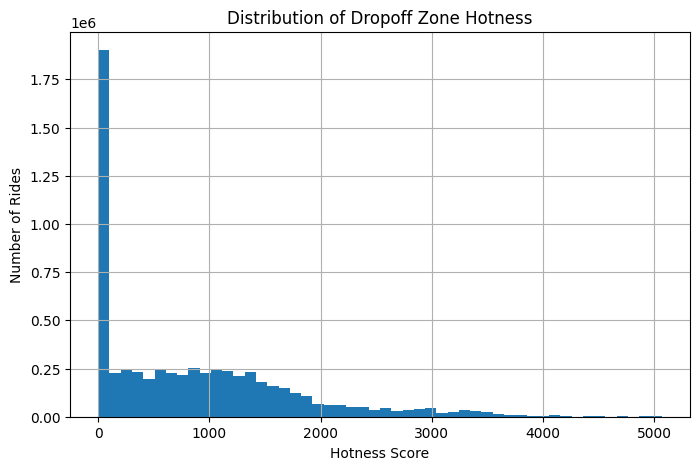

In [27]:
#checking the distribution of dropoff zone hotness
df_ma['dropoff_zone_hotness'].describe()

# histogram of dropoff zone hotness
plt.figure(figsize=(8, 5))
df_ma['dropoff_zone_hotness'].hist(bins=50)
plt.title('Distribution of Dropoff Zone Hotness')
plt.xlabel('Hotness Score')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

## Discussion

There is a heavy spike at 0 --> most dropoffs occured in zones that rerely (or never) show up in the full Jan_April data, ie these are less popular or less trafficked zones

There is a long tail to the right: A smaller number of zones (airports, downtown, midtown) dominate dropoff traffic and have very high hoteness scores 

This feature does a good job at capturing real-world zone demand patterns


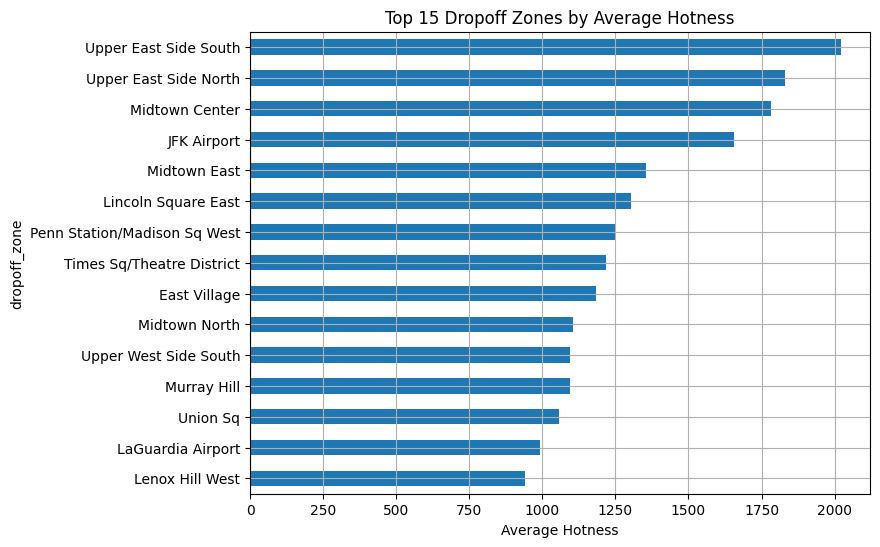

In [28]:
#looking at top hot zones
df_ma.sort_values('dropoff_zone_hotness', ascending=False)[
    ['dropoff_zone', 'dropoff_zone_hotness']
].drop_duplicates().head(10)

zone_avg_hotness = df_ma.groupby('dropoff_zone')['dropoff_zone_hotness'].mean()
zone_avg_hotness = zone_avg_hotness.sort_values(ascending=False).head(15)

zone_avg_hotness.plot(kind='barh', figsize=(8, 6))
plt.title('Top 15 Dropoff Zones by Average Hotness')
plt.xlabel('Average Hotness')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


## Discussion

The top dropoff zones include Manhattan commerical/residential hubs (midtown, upper east, union sq, Murray Hill) and transit heavy locations (penn station, airports) this esetially confirms that this feature is caputring real world demand zones, showing the difference between high/low traffic areas

In [29]:
#spot checking a few examples
df_ma[['tpep_dropoff_datetime', 'dropoff_zone', 'dropoff_zone_hotness']].sample(5)


,tpep_dropoff_datetime,dropoff_zone,dropoff_zone_hotness
2483302,2023-04-25 11:04:43-04:00,UN/Turtle Bay South,700.0
2915286,2023-04-29 00:20:12-04:00,East Chelsea,956.0
3384123,NaT,Kips Bay,0.0
4424773,2023-03-13 17:18:56-04:00,World Trade Center,288.0
1133791,2023-04-12 16:50:29-04:00,Clinton West,265.0


## Discussion 

This just shows that the data was correctly mergerd fir the hotenss values back into indicidual ride rows. It shows reasonsable values: high hoteness for pleces like Time Sq and low hotness for neighborhoods like Port Morris

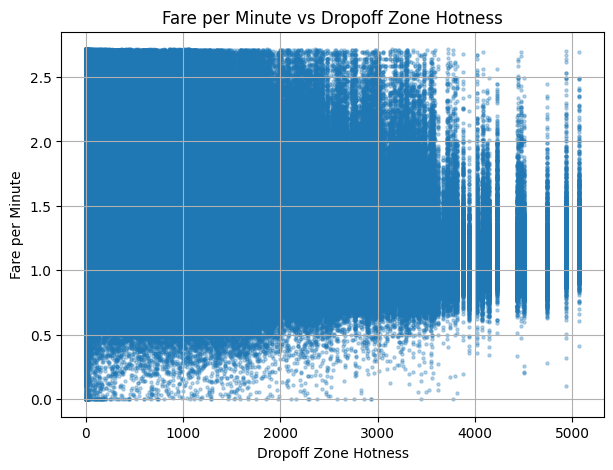

In [30]:
#checking correlation with fare
df_ma[['dropoff_zone_hotness', 'fare_per_minute']].corr()

# Scatter plot of fare per minute vs dropoff zone hotness
plt.figure(figsize=(7, 5))
plt.scatter(df_ma['dropoff_zone_hotness'], df_ma['fare_per_minute'], alpha=0.3, s=5)
plt.title('Fare per Minute vs Dropoff Zone Hotness')
plt.xlabel('Dropoff Zone Hotness')
plt.ylabel('Fare per Minute')
plt.grid(True)
plt.show()


## Discussion

This is very useful. 

There is a dense cluster of low-to-mid fares/minutes rides across all hotness levels.

There us a broad spread of fare_per_minute even in the most popular zones, and there is no simple linear realtionship, meaning that hot zones dont neccistate higher earnings

This shows that dropoff_zone_hotness is not redundant with fare_per_minute, and that it will add distinict value to the final scoring model by capturing pickup oppotunity, not just earnings

## Trip Duration Variablity

We will now be moving on to coding and checking this feature also apart of our scoring feature

In [31]:
print(df_ma.columns)


Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'dropoff_borough', 'dropoff_zone',
       'dropoff_service_zone', 'fare_per_minute', 'fare_per_mile',
       'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend',
       'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip',
       'dropoff_day_of_week', 'dropoff_hour', 'pickup_zone_y',
       'pickup_day_of_week_y', 'pickup_hour_y', 'dropoff_zone_hotness'],
      dtype='object')


In [ ]:
# Calculating trip duration variability by pickup context
#  Rename columns first
df_ma.rename(columns={
    'pickup_hour_x': 'pickup_hour',
    'pickup_day_of_week_x': 'pickup_day_of_week',
    'pickup_zone_x': 'pickup_zone'
}, inplace=True)

# Define grouping keys
group_cols = ['pickup_zone', 'dropoff_zone', 'pickup_day_of_week', 'pickup_hour']

# Compute duration variability stats
duration_stats = (
    df_ma.groupby(group_cols)['trip_duration_min']
         .agg(['mean', 'std', 'count'])
         .reset_index()
         .rename(columns={'std': 'duration_variability'})
)

# Drop any existing version to avoid conflict
df_ma.drop(columns=['duration_variability'], errors='ignore', inplace=True)

# Merge cleanly now
df_ma = df_ma.merge(
    duration_stats[group_cols + ['duration_variability']],
    on=group_cols,
    how='left'
)

## Light Evaluation

In [46]:
# Summary stats
print("Trip Duration Variability Summary:")
print(df_ma['duration_variability'].describe())


Trip Duration Variability Summary:
count    6.076039e+06
mean     4.195993e+00
std      2.635107e+00
min      0.000000e+00
25%      2.687326e+00
50%      3.608592e+00
75%      4.907520e+00
max      1.485278e+02
Name: duration_variability, dtype: float64


## Discussion

The typical variability is low (median ~3.6 mins), but outliers exist (some trips have std > 100 mins).

Indicates a non-normal distribution with important tail risks.

High-variability outliers may be noise or legitimate long, inconsistent trips — you may want to cap or filter them.

Gives a sense of scale when combining this feature with others like fare_per_minute.

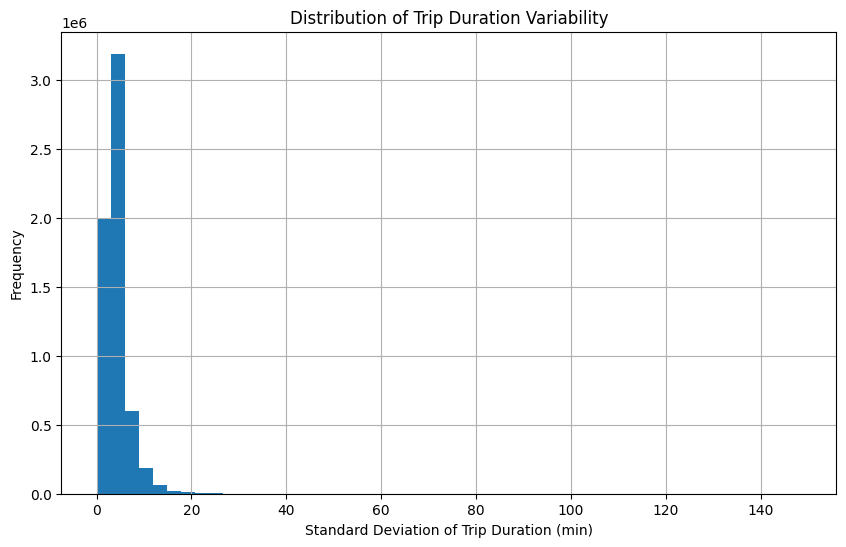

In [48]:
# Histogram of trip duration variability
plt.figure(figsize=(10, 6))
df_ma['duration_variability'].hist(bins=50)
plt.title("Distribution of Trip Duration Variability")
plt.xlabel("Standard Deviation of Trip Duration (min)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Discussion

This histogram displays the stanrdard deviation of trip durations acorss all grouped pickup-dropoffs --> most trips have a variability between 2-6mins, there is a long tail again that shows much higher variability from longer trips 

This skewed distribution shows that while many routes are predictable a subset introduces significant risk to earnings due to delays

might want to consider having our scoring system to penalize high-variability trips, espically when a driver is aiming for efficiency or consistency

<Figure size 1200x600 with 0 Axes>

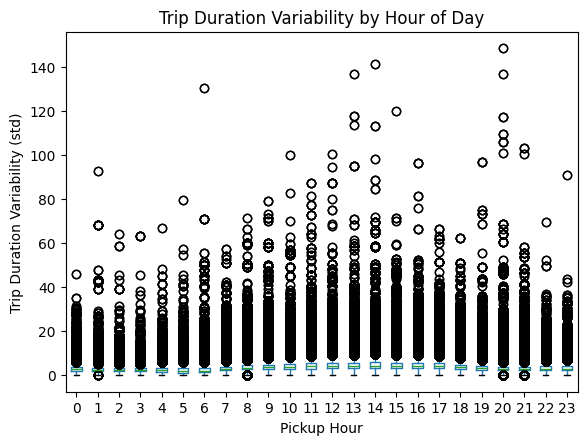

In [50]:
#Explore variability by time of day
plt.figure(figsize=(12, 6))
df_ma.boxplot(column='duration_variability', by='pickup_hour', grid=False)
plt.title("Trip Duration Variability by Hour of Day")
plt.suptitle("")  # Remove default title
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration Variability (std)")
plt.show()

## Discussion

Each box represents the spread of duration variability (std) for trips occurring at each hour of day. There is an increased median and spread during midday and afternoon hours (e.g., 12–18), consistent with traffic buildup.

Some hours of the day are less predictable — understanding this helps build smarter decision tools for shift planning.

We could apply hour-of-day penalties in your ride scoring or use it to refine trip_duration_variability? Bring this up to the group later and see what they think

<Figure size 1000x600 with 0 Axes>

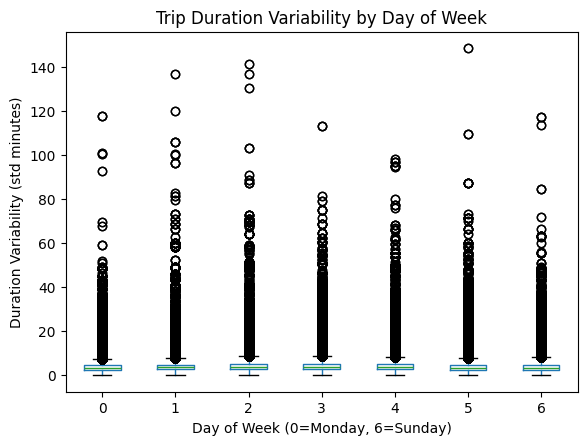

In [51]:
# Boxplot grouped by pickup day of week
plt.figure(figsize=(10, 6))
df_ma.boxplot(column='duration_variability', by='pickup_day_of_week', grid=False)
plt.title("Trip Duration Variability by Day of Week")
plt.suptitle("")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Duration Variability (std minutes)")
plt.xticks(rotation=0)
plt.show()


## Discussion

Distribution of duration variability grouped by pickup day of the week (0 = Monday, 6 = Sunday).

Weekends (especially Friday/Saturday) show slightly higher spread, which may reflect more unpredictable traffic or late-night congestion.

Reinforces that weekday vs. weekend is a relevant input for trip predictability.

Could help decide whether to train separate models or include day_type as a feature.

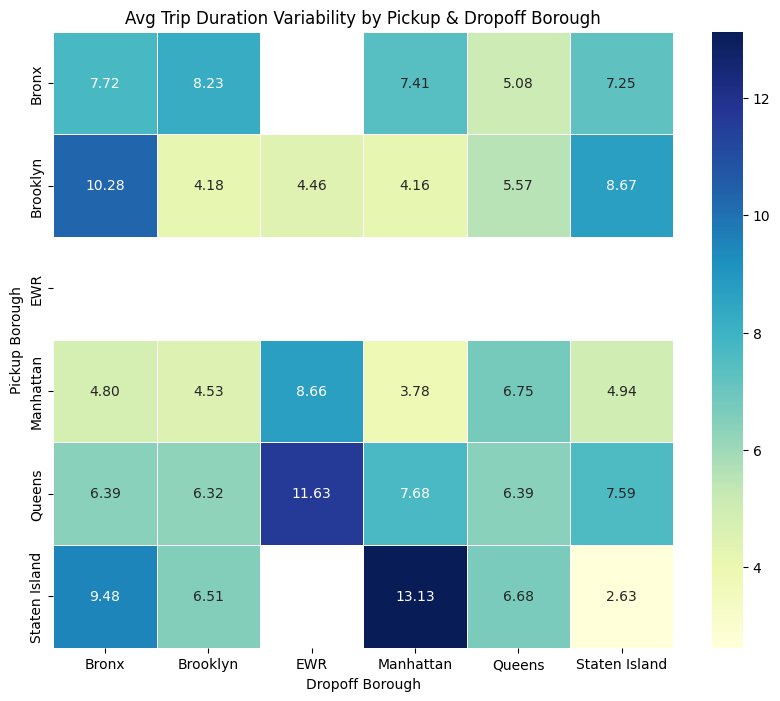

In [53]:

# Group by pickup/dropoff borough and take the average variability
heatmap_data = (
    df_ma.groupby(['pickup_borough', 'dropoff_borough'])['duration_variability']
         .mean()
         .unstack()
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Avg Trip Duration Variability by Pickup & Dropoff Borough")
plt.xlabel("Dropoff Borough")
plt.ylabel("Pickup Borough")
plt.show()


## Discussion

Average trip duration variability for every borough-to-borough pair.

Darker cells (e.g., Staten Island → Manhattan, Queens → EWR) show more unpredictable trips.

Lighter cells (e.g., Brooklyn → Manhattan, Manhattan → Manhattan) are relatively stable.

Helps visually spot risky trip types (e.g., outer boroughs or airport routes).

This could guide:

Route recommendations

Scoring penalties

Driver alerts about expected delays